Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully!
Class Names: ['0.0', '1.0', '2.0']
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2370/2370 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.3989 - loss: 1.1881 - val_accuracy: 0.0000e+00 - val_loss: 1.6780 - learning_rate: 0.0010
Epoch 2/100
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.4371 - loss: 1.0249 - val_accuracy: 0.0000e+00 - val_loss: 1.6923 - learning_rate: 0.0010
Epoch 3/100
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4429 - loss: 1.0211 - val_accuracy: 0.0000e+00 - val_loss: 1.7174 - learning_rate: 0.0010
Epoch 4/100
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4447 - loss: 1.0180 - val_accuracy: 0.0000e+00 - val_loss: 1.6892 - learning_rate: 0.0010
Epoch 5/100
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.4516 - loss: 1.0119 - val_accuracy: 0.0061 - val_loss: 1.6441 - learning_rate: 0.0010
Epoch 6/100
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4507 - loss: 1.0090 - val_accuracy: 0.1375 - val_loss: 1.5588 - learning_rate: 0.0010
Epoch 7/100
2370/2370 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accur

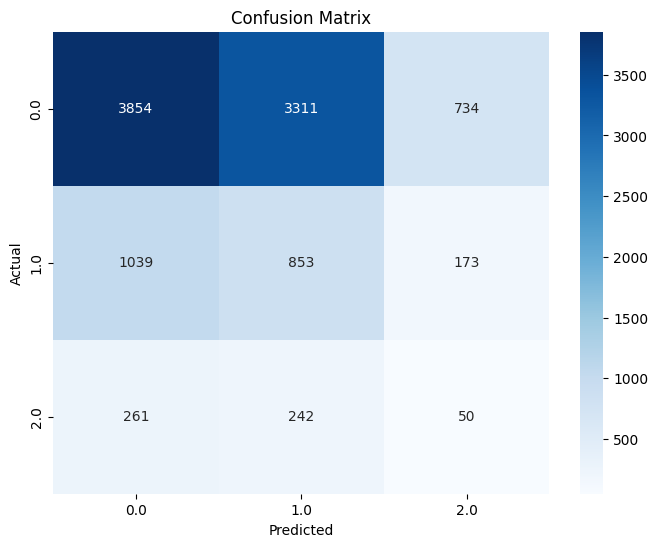

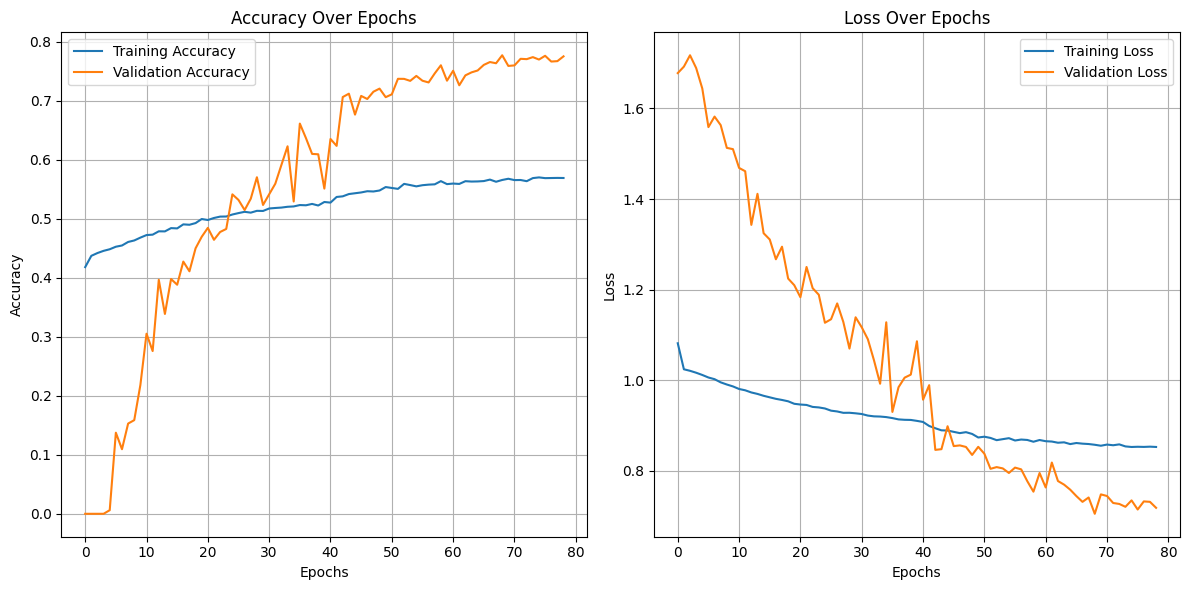

In [9]:
# Install required libraries
!pip install tensorflow pandas matplotlib seaborn imbalanced-learn

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
data_path = '/content/drive/My Drive/ML Mental Health Monitoring System/data.csv'
data = pd.read_csv(data_path)
print("Dataset loaded successfully!")

# Define features and target
features = [
    'Heart_Rate', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
    'Skin_Temperature', 'Respiration_Rate', 'Sleep_Duration',
    'Activity_Levels', 'Mood', 'Stress_Level', 'Resilience_Factors'
]
target = 'Mental_Health_Status'

# Encode target variable
label_encoder = LabelEncoder()
data[target] = label_encoder.fit_transform(data[target])
class_names = list(map(str, label_encoder.classes_))  # Ensure class_names is a list of strings
print("Class Names:", class_names)

# Fill missing values
data[features] = data[features].fillna(data[features].median())

# Train-test split
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Convert target to categorical for multi-class classification
num_classes = len(np.unique(y))
y_train_cat = tf.keras.utils.to_categorical(y_train_balanced, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# Build the Fully Connected Neural Network (FNN)
model = Sequential([
    Dense(512, activation='relu', input_dim=X_train_scaled.shape[1]),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train_balanced, y_train_cat,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))  # class_names should now work properly

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
